# This is Project 4 - Advanced Lane Line - Author: Qitong Hu

## Camera Calibration

### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

### imports and helper functions

In [3]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import glob

OUTPUT_IMAGE_DIR = 'output_images/'

In [4]:
def plot_figures(figures, nrows = 1, ncols=1):
    # from http://stackoverflow.com/questions/11159436/multiple-figures-in-a-single-window
    """Plot a dictionary of figures.
    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """
    if type(figures) is list:
        figures = dict(zip(range(len(figures)), figures))
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows)
    for ind,title in zip(range(len(figures)), figures):
        axeslist.ravel()[ind].imshow(figures[title], cmap=plt.gray())
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
        
def show_two_images(image1, image2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(image2)
    ax2.set_title('Transformed Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    
def get_output_image_path(original_image_path, prefix=''):
    return os.path.join(OUTPUT_IMAGE_DIR, prefix+os.path.basename(original_image_path)) 

### Camera Calibration to Undistortion

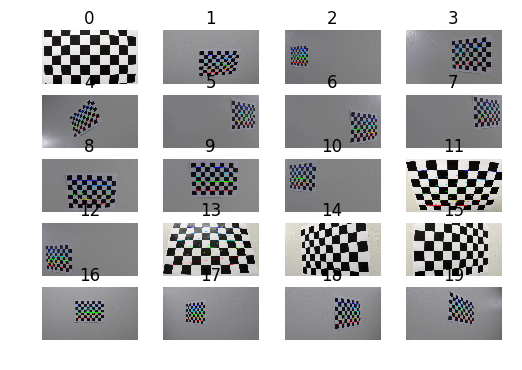

In [5]:
image_names = glob.glob('camera_cal/calibration*.jpg')
images = [mpimg.imread(image_path) for image_path in image_names]

objpoints = [] #(0,0,0) -> (8,5,0)
imgpoints = []
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
i =0
for img in images:
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        i+=1
plot_figures(images,5,4)

In [6]:
img_size = (images[0].shape[1], images[0].shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

In [7]:
def undistort_image(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

In [8]:
src = np.array([[330,625],[965,625],[550,475],[730,475]], np.float32)
dst = np.array([[400,625],[1035,625],[400,400],[1035,400]], np.float32)

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

def perspective_transform(image):
    warped = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
    return warped

In [9]:
def test_undistort_on_image_from_path(image_path):
    original_image = mpimg.imread(image_path)
    undist_image = undistort_image(original_image)
    show_two_images(original_image, undist_image)
    output_image_path = get_output_image_path(image_path,'undistorted_')
    mpimg.imsave(output_image_path, undist_image)

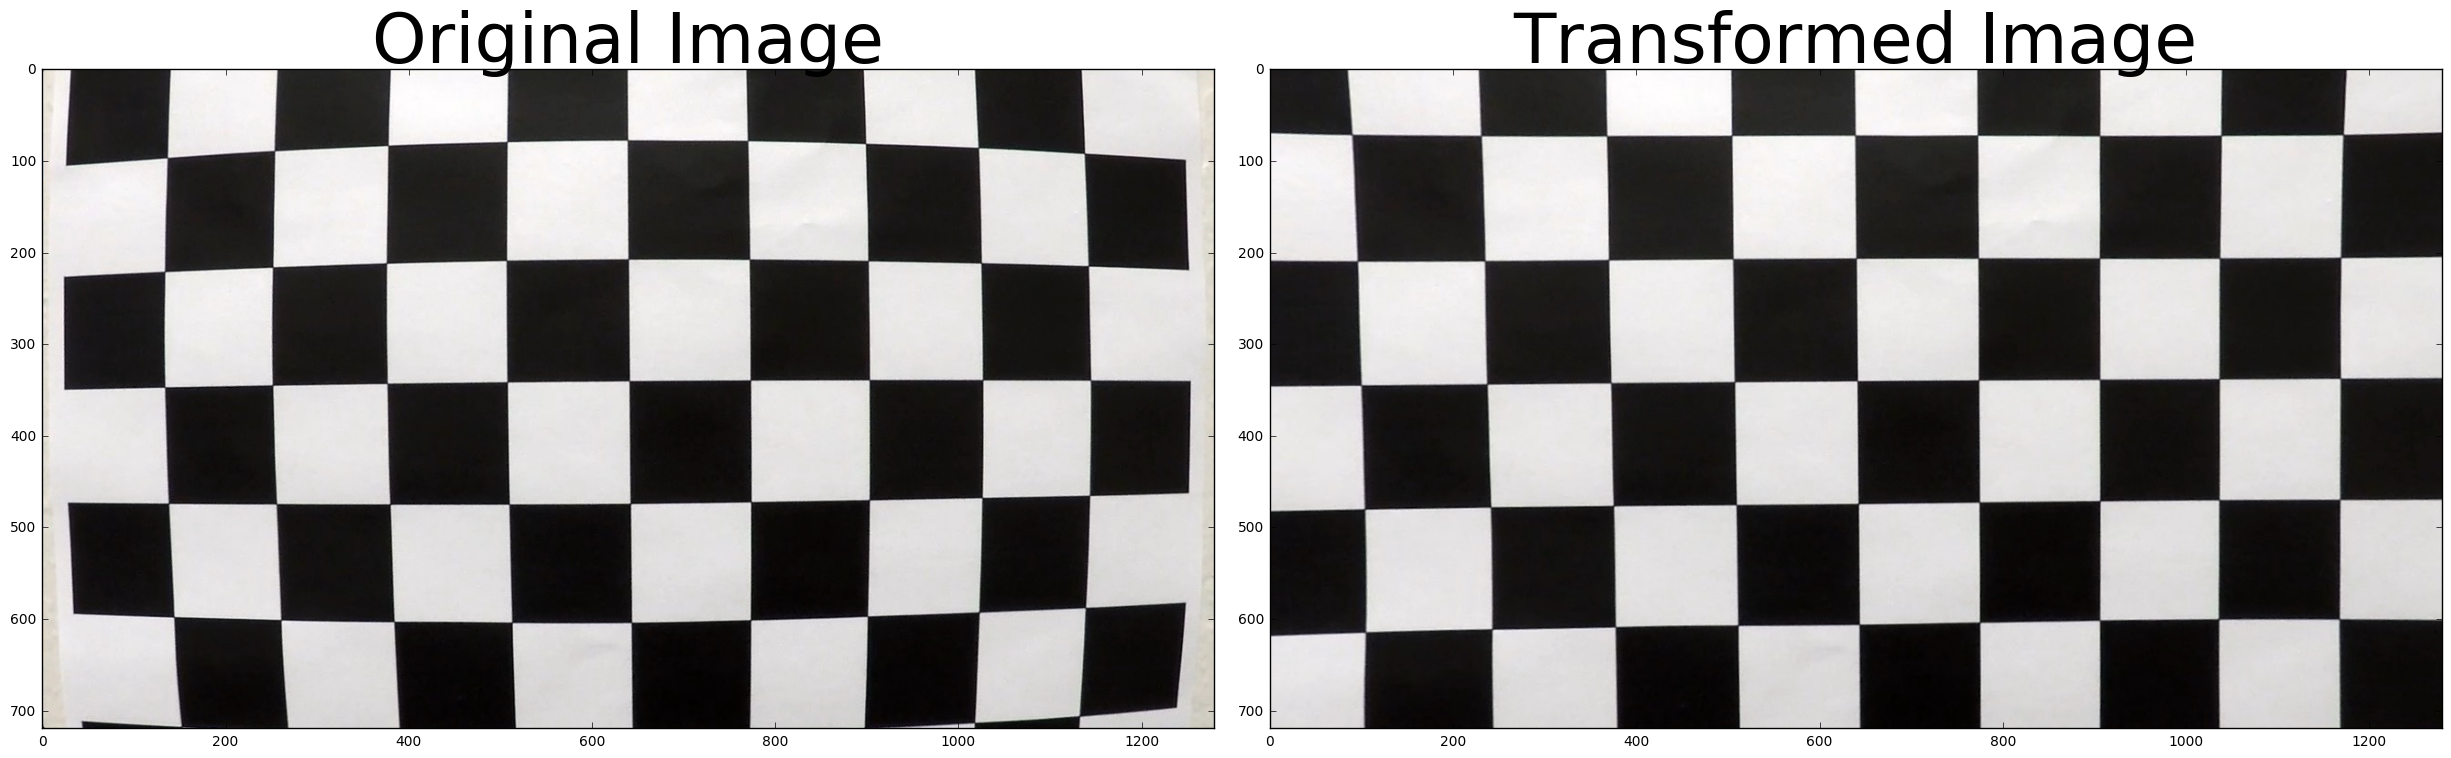

In [10]:
test_undistort_on_image_from_path('camera_cal/calibration1.jpg')

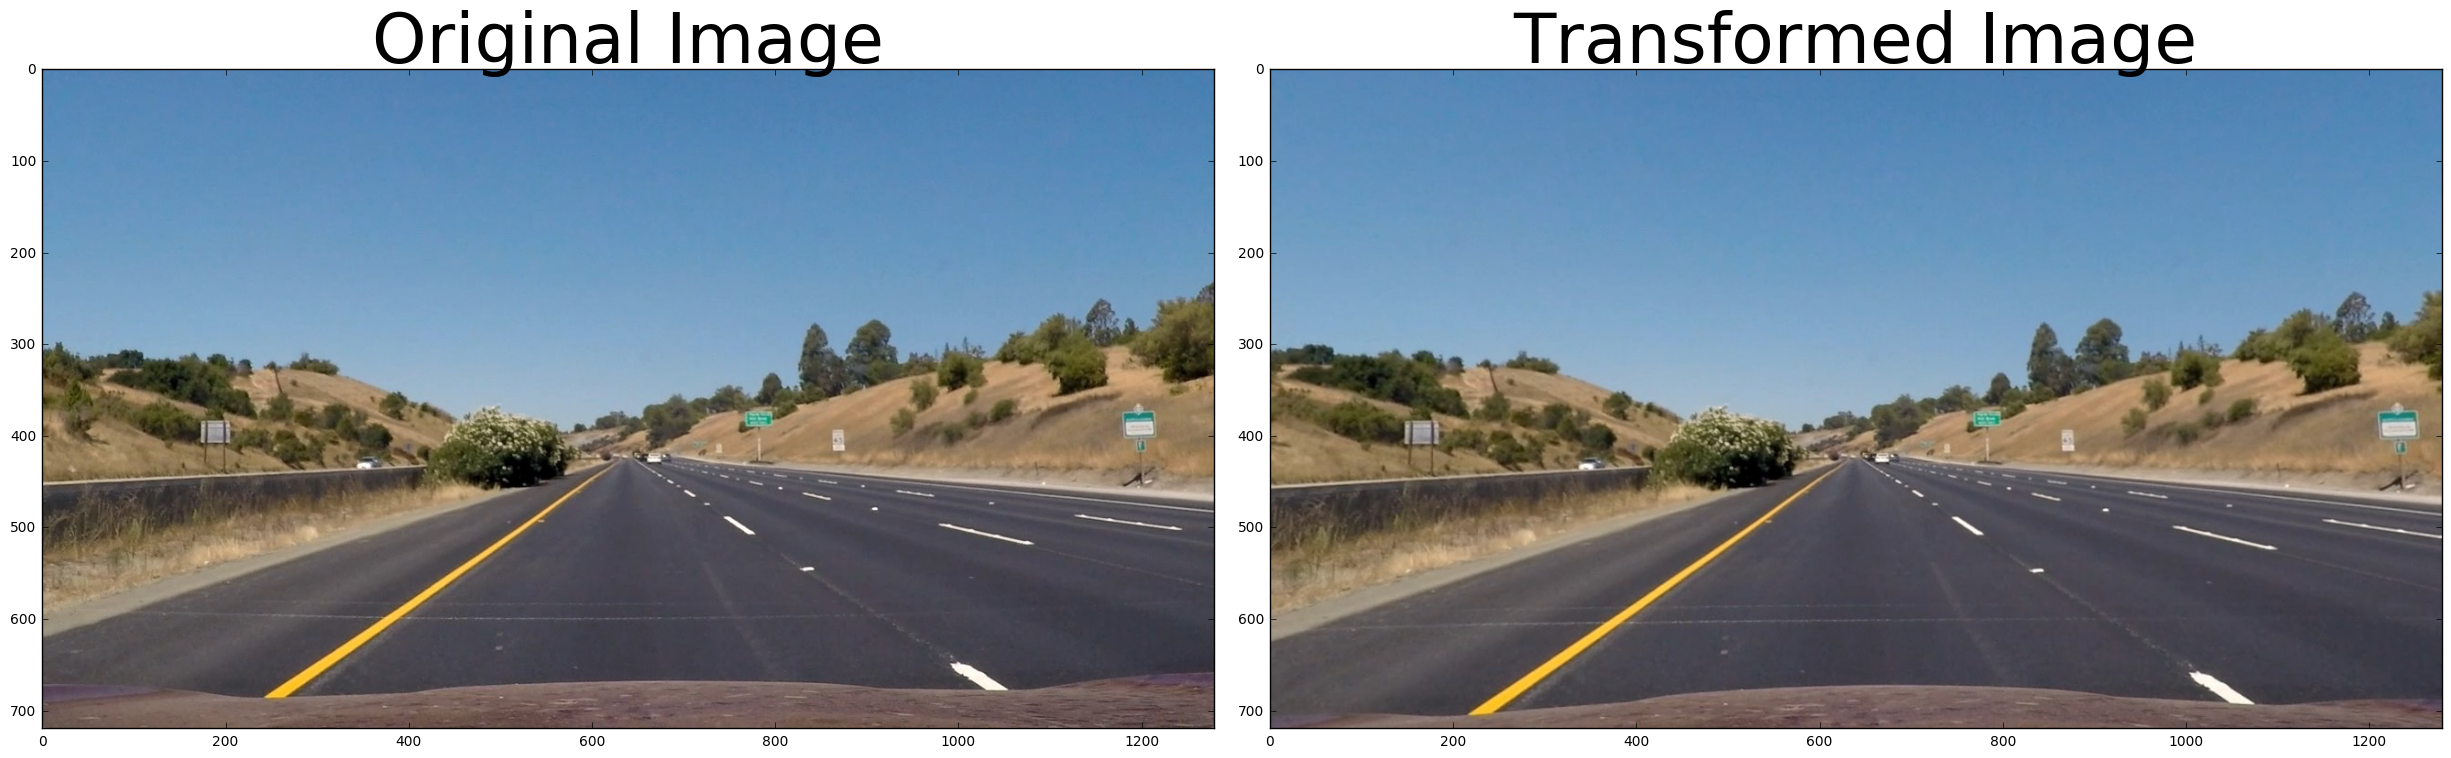

In [11]:
test_undistort_on_image_from_path('test_images/straight_lines1.jpg')

### Sobel Gradient and HLS Threshold

In [12]:
X_THRESH = (110, 205)
Y_THRESH = (70, 200)
MAG_THRESH = (40, 250)
DIR_THRESH = (0.8, 1.5)
K_SIZE = 3

In [13]:
def scaled_image(image):
    scaled_image = np.uint8(image * 255 / np.max(image))
    return scaled_image

def shrink_image_over_thresh(image, thresh=(0,0,0)):
    shrinked = np.zeros(image.shape[:-1])
    shrinked[(image[:,:,0]>thresh[0]) | (image[:,:,1]>thresh[1]) | (image[:,:,2]>thresh[2])] = 1
    return shrinked

In [14]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    abs_sobel = _abs_sobel_at_orient(image, orient, sobel_kernel)
    scaled_sobel = np.uint8(abs_sobel * 255 / np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    sobelx = _abs_sobel_at_orient(image, 'x', sobel_kernel)
    sobely = _abs_sobel_at_orient(image, 'y', sobel_kernel)
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    mag_binary = np.zeros_like(magnitude)
    mag_binary[(magnitude >= mag_thresh[0]) & (magnitude <= mag_thresh[1])] = 1
    return mag_binary


def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    sobelx = _abs_sobel_at_orient(image, 'x', sobel_kernel)
    sobely = _abs_sobel_at_orient(image, 'y', sobel_kernel)
    direction = np.arctan2(sobely, sobelx)
    dir_binary = np.zeros_like(sobelx)
    dir_binary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return dir_binary


def _abs_sobel_at_orient(image, orient='x', sobel_kernel=3):
    if orient == 'x':
        sobel = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    return np.absolute(sobel)
    

In [15]:
def hls_thresh(image, thresh=(0, 255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return s_binary

In [16]:
def sobel_on_image(image):
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=X_THRESH)
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=3, thresh=Y_THRESH)
    mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=MAG_THRESH)
    dir_binary = dir_threshold(image, sobel_kernel=3, thresh=DIR_THRESH)

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

In [17]:
def test_sobel_on_image_from_path(image_path):
    original_image = mpimg.imread(image_path)
    gray = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
    sobeled_image = sobel_on_image(gray)
    #sobeled_image = shrink_image_over_thresh(sobeled_image)
    show_two_images(original_image, sobeled_image)
    output_image_path = get_output_image_path(image_path,'sobeled_')
    mpimg.imsave(output_image_path, sobeled_image)

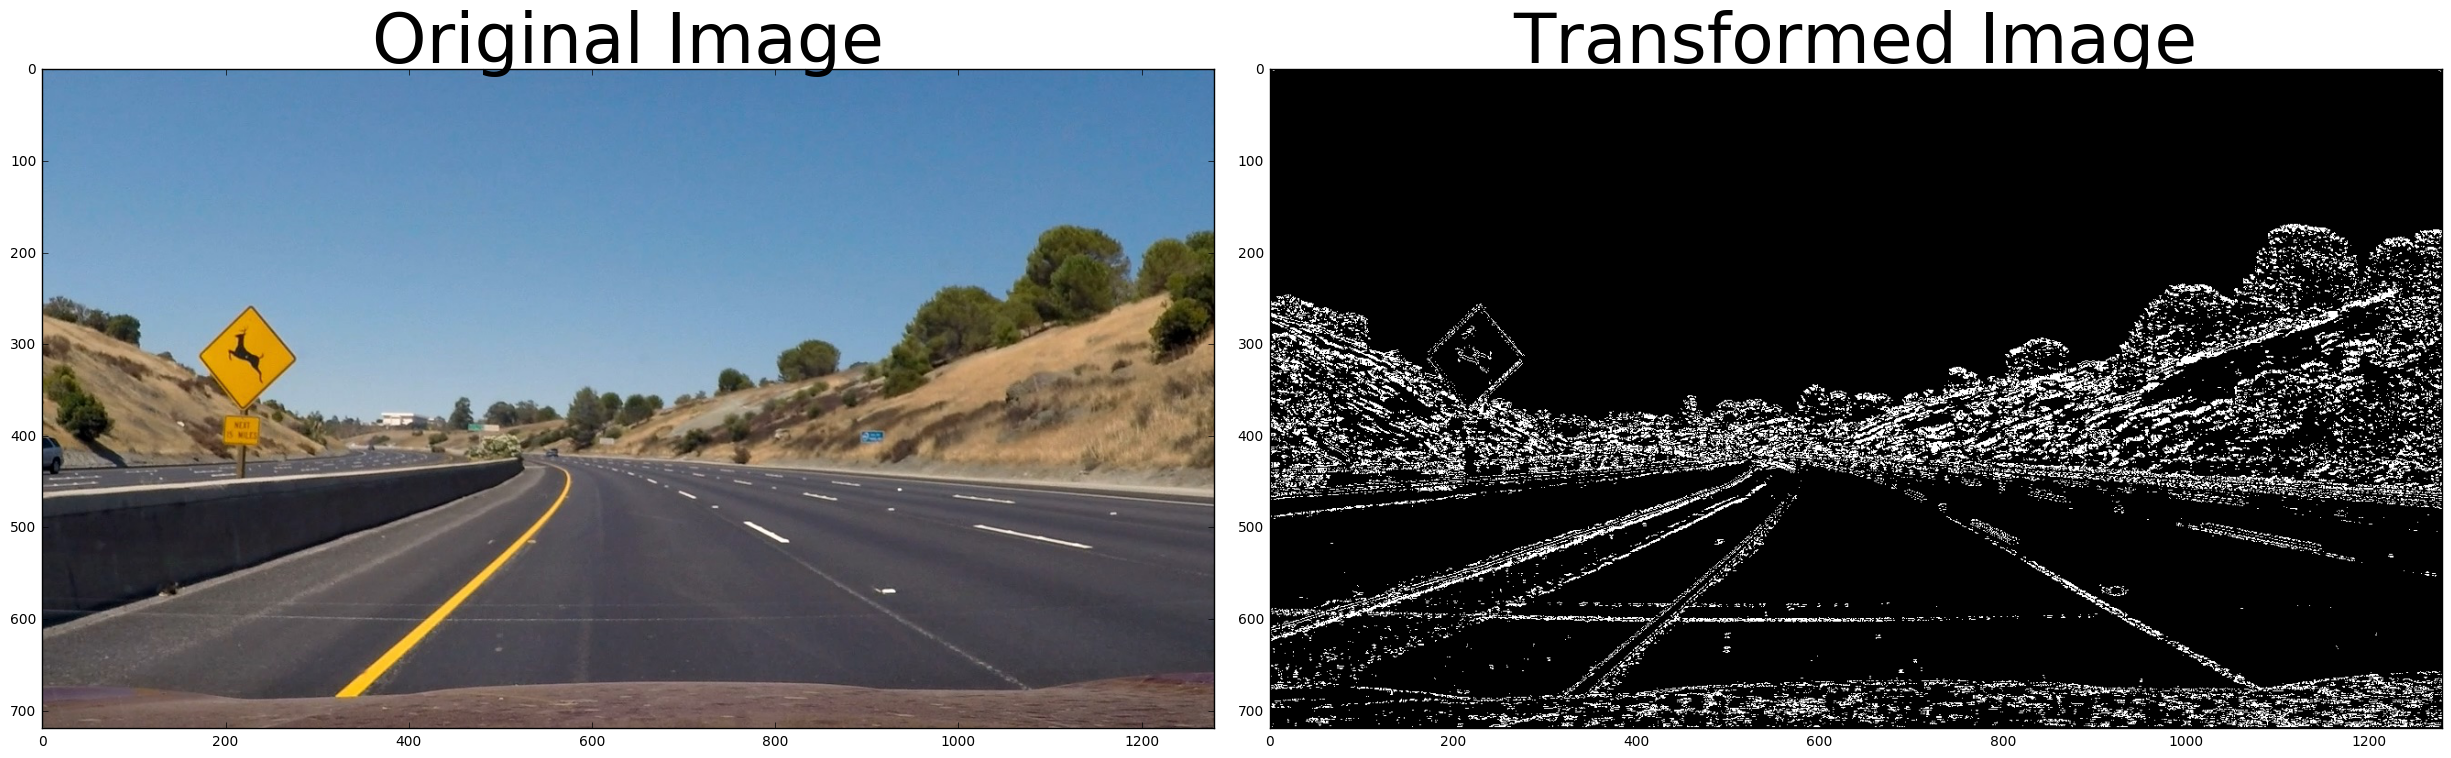

In [18]:
test_sobel_on_image_from_path('test_images/test2.jpg')

### Perspective Transfrom

In [19]:
src = np.array([[255,678],[1053,678],[556,475],[729,475]], np.float32)
dst = np.array([[400,625],[1035,625],[400,400],[1035,400]], np.float32)

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

In [20]:
def perspective_transform(image):
    warped = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
    return warped

In [21]:
def test_prespective_transform_on_image_from_path(image_path):
    original_image = mpimg.imread(image_path)
    original_image = undistort_image(original_image)
    prespective_trans_image = perspective_transform(original_image)
    show_two_images(original_image, prespective_trans_image)
    output_image_path = get_output_image_path(image_path,'perspective_')
    mpimg.imsave(output_image_path, prespective_trans_image)

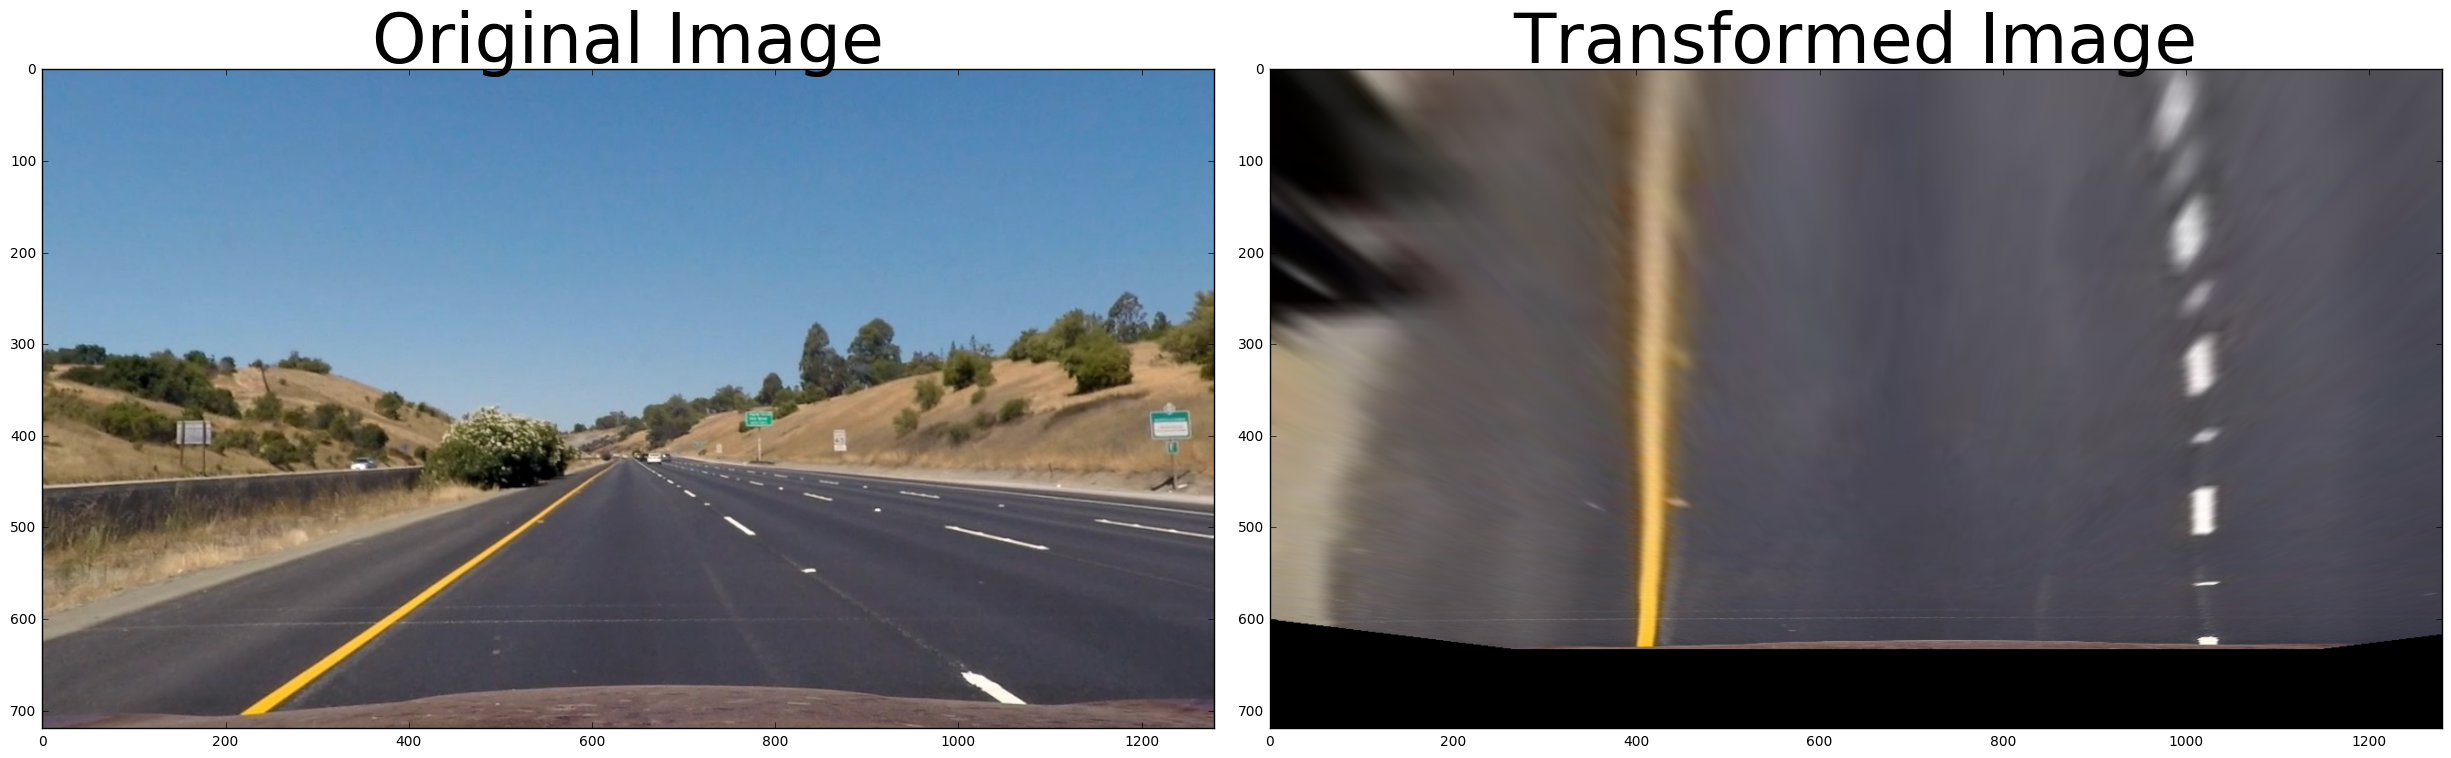

In [22]:
test_prespective_transform_on_image_from_path('test_images/straight_lines1.jpg')

### Region of Interest

In [23]:
VERTICES = np.array([[(350, 650),(1200, 650),(1200,180),(350, 180)]], dtype=np.int32)

In [24]:
def region_of_interest(img, vertices=VERTICES):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

#### HSV threshold to remove shadow

In [30]:
def HSV_thresh(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v = hsv[:,:,2]
    v_binary = np.zeros_like(v)
    v_binary[(v >= 100)] = 1
    return v_binary

In [31]:
def pipeline(color_image):
    color_image = undistort_image(color_image)
    sobel = sobel_on_image(color_image)
    sobel = shrink_image_over_thresh(sobel)
    v_binary = HSV_thresh(color_image)
    combined = np.zeros_like(sobel)
    combined[((sobel>0) & (v_binary>0))] = 1
    scaled_sobel = scaled_image(combined)
    perspective = perspective_transform(scaled_sobel)
    roi = region_of_interest(perspective)
    return roi

In [32]:
def processing_pipeline_test_on_image_path(image_path):
    image = mpimg.imread(image_path)
    roi = pipeline(image)
    warped = cv2.warpPerspective(roi, Minv, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
    show_two_images(image,warped)

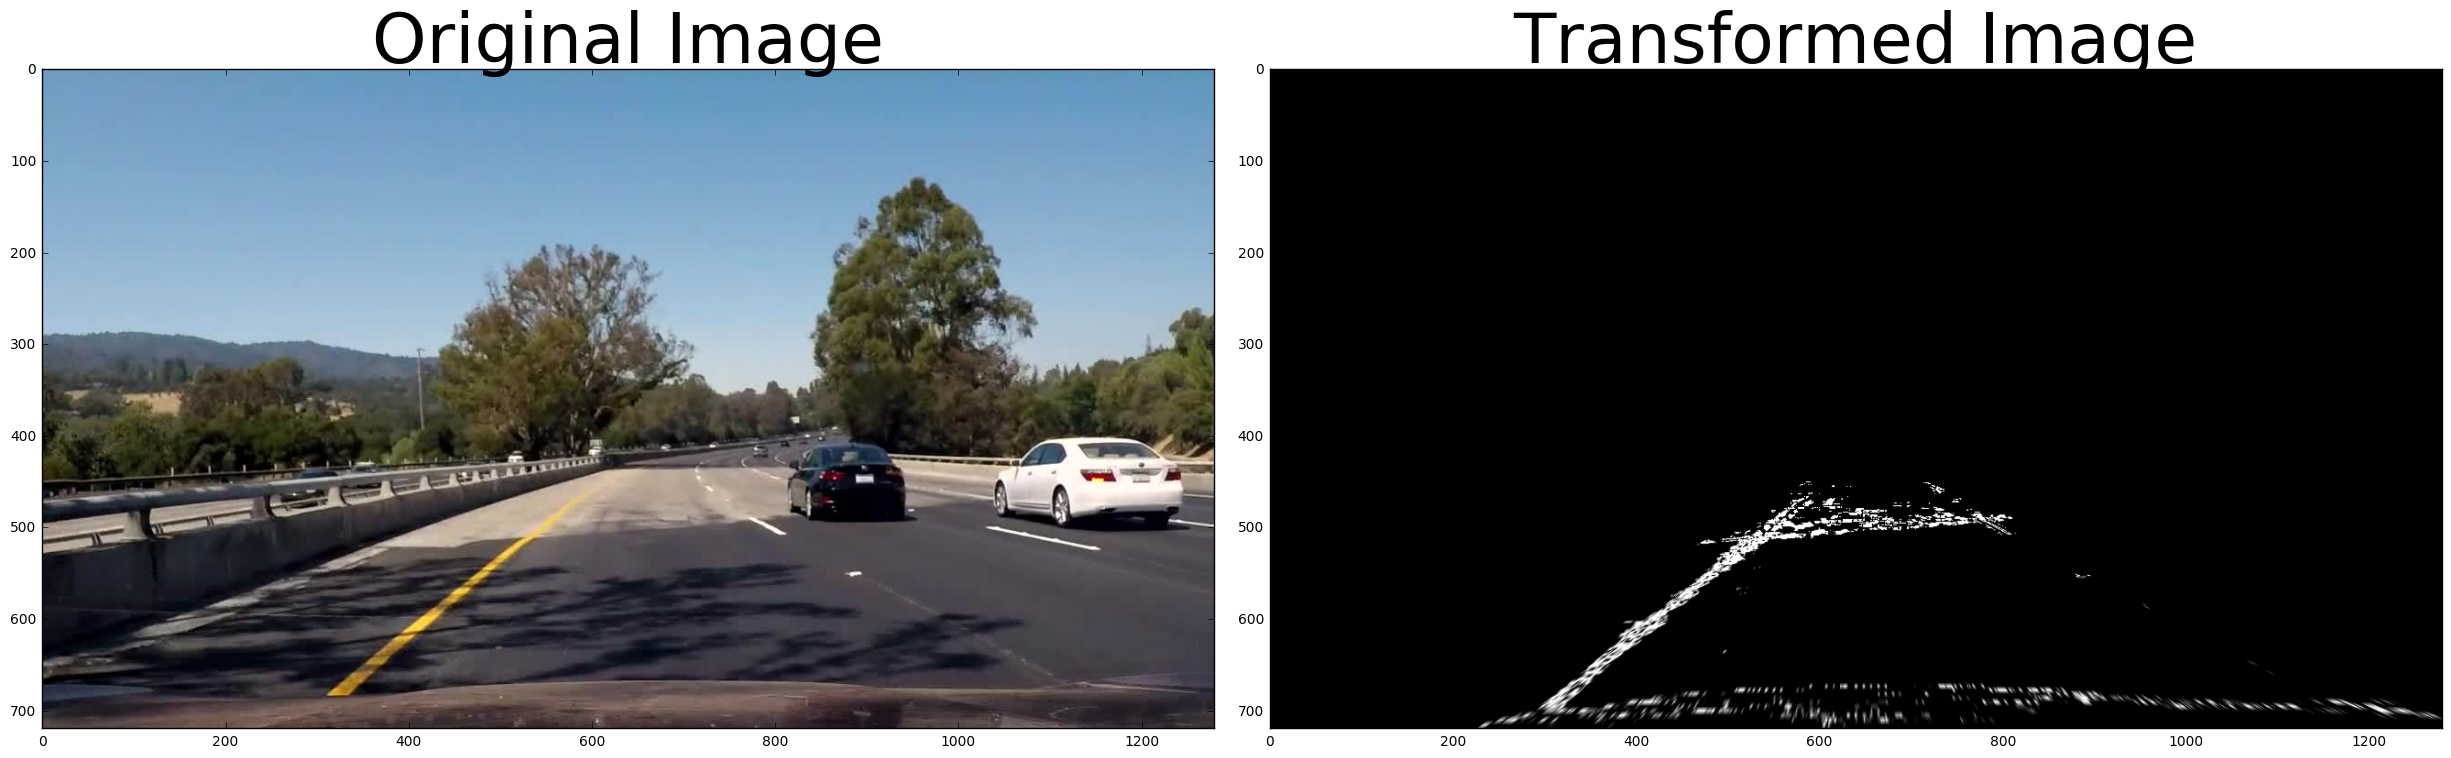

In [33]:
processing_pipeline_test_on_image_path('test_images/frame_39_5.jpg')

### Polynomial Fit

In [34]:
RETURN_POINTS = 0
RETURN_POLY_COEFFICIENT = 1
RETURN_DRAW = 2
RETURN_DATA_POINT = 3

def find_curve_function(binary_warped,return_mode=RETURN_POINTS):
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
        left_lane_inds.append(good_left_inds) ######
        right_lane_inds.append(good_right_inds)#####
        
    # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
#             left_lane_inds.append(good_left_inds) 
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
#             right_lane_inds.append(good_right_inds)
# Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    if return_mode == RETURN_DATA_POINT:
        return leftx, lefty, rightx, righty 
    
# Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    if return_mode == RETURN_POLY_COEFFICIENT:
        return left_fit, right_fit, ploty
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if return_mode == RETURN_POINTS:
        return left_fitx, right_fitx, ploty
    
# Draw out image
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    #return left_fitx, right_fitx, ploty, out_img

In [35]:
def test_polynomial_fit_on_image_from_path(image_path):
    original_image = mpimg.imread(image_path)
    roi = pipeline(original_image)
    find_curve_function(roi, return_mode=RETURN_DRAW)

/Users/qitonghu/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


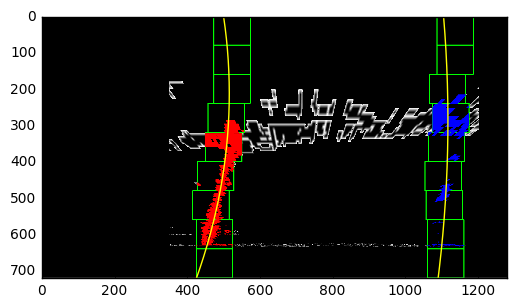

In [36]:
test_polynomial_fit_on_image_from_path('test_images/frame_39.jpg')

### Draw back on road

In [37]:
def drawback_on_road(image, warped, left_fitx, right_fitx, ploty, Minv, undist):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result
    #plt.imshow(result)

In [38]:
def test_drawback_on_road_on_image_path(image_path):
    img = mpimg.imread(image_path)
    undist = undistort_image(img)
    cool = pipeline(img)
    left, right, y = find_curve_function(cool)
    result = drawback_on_road(img, cool, left, right, y, Minv, undist)
    plt.imshow(result)

/Users/qitonghu/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


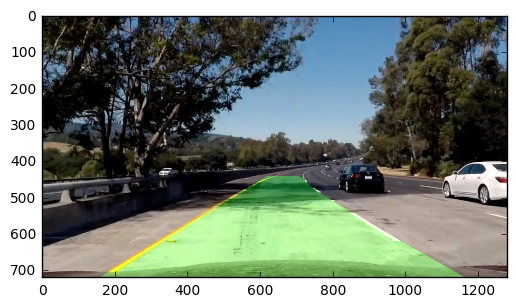

In [39]:
test_drawback_on_road_on_image_path('test_images/test5.jpg')

### Extra Optimization

### Calculate Curvation

In [40]:
def calculate_pixel_space_curvation(ploty, left_fit, right_fit):
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return (left_curverad, right_curverad)
    # Example values: 1926.74 1908.48

In [41]:
def test_calculate_pixel_space_curvation_on_image_path(image_path):
    img = mpimg.imread(image_path)
    cool = pipeline(img)
    left, right, y = find_curve_function(cool, return_mode=RETURN_POLY_COEFFICIENT)
    result = calculate_pixel_space_curvation(y, left, right)
    print(result)
    plt.imshow(img)

/Users/qitonghu/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(3156.6035917968784, 17109.471721132995)


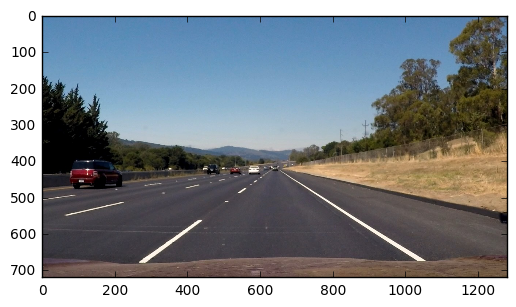

In [42]:
test_calculate_pixel_space_curvation_on_image_path('test_images/straight_lines2.jpg')

In [43]:
def calculate_real_world_curvation(leftx, lefty, rightx, righty):
    y_eval = np.max(lefty)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')

In [44]:
def test_calculate_real_world_curvation_on_image_path(image_path):
    img = mpimg.imread(image_path)
    cool = pipeline(img)
    leftx, lefty, rightx, righty = find_curve_function(cool, return_mode=RETURN_DATA_POINT)
    result = calculate_real_world_curvation(leftx, lefty, rightx, righty)
    plt.imshow(img)
    print(result)

/Users/qitonghu/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


244.317923174 m 217.219139983 m
None


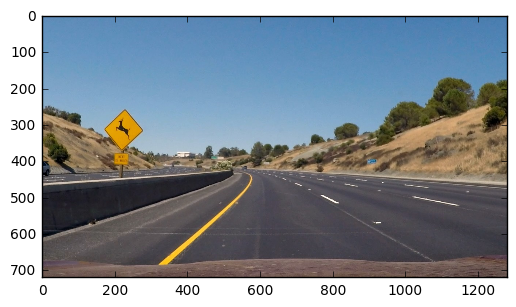

In [47]:
test_calculate_real_world_curvation_on_image_path('test_images/test2.jpg')

### Perform detection on video

In [48]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [49]:
def process_image(image):
    undist = undistort_image(image)
    cool = pipeline(image)
    left, right, y = find_curve_function(cool)
    result = drawback_on_road(image, cool, left, right, y, Minv, undist)
    return result

In [50]:
proj_output = 'project_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
proj_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time proj_clip.write_videofile(proj_output, audio=False)

[MoviePy] >>>> Building video project_out.mp4
[MoviePy] Writing video project_out.mp4


100%|█████████▉| 1260/1261 [11:19<00:00,  1.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_out.mp4 

CPU times: user 9min 16s, sys: 3min 15s, total: 12min 32s
Wall time: 11min 19s


In [51]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(proj_output))

### Challenge Video

In [488]:
def process_video_from_path(video_path):
    output_name = video_path.split('.')[0]+'_output.mp4'
    clip = VideoFileClip(video_path)
    video_clip = clip.fl_image(process_image)
    %time video_clip.write_videofile(output_name, audio=False)
    return output_name

In [491]:
output = process_video_from_path('challenge_video.mp4')
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [04:18<00:00,  1.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 3min 33s, sys: 1min 13s, total: 4min 47s
Wall time: 4min 19s
